<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 3 - Aplicaciones de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Modelos Generativos profundos: VAE (*Variational Autoencoder*) y GAN (*Generative Adversarial Network*).
* Arquitectura encoder-decoder y mecanismo de antención.
* Desafío en donde se aplique todo lo aprendido.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: -
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Modelos Generativos  
[2.](#segundo) *Question-Answering*  
[3.](#tercer) Challenge (*Object Counting*)

*Nota: Para esta actividad, al igual que anteriores, si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*

<a id="segundo"></a>
## 2. *Question Answering*

Las redes neuronales recurrentes hoy en día han sido aplicadas a varios problemas que involucran dependencia temporal de los datos de entrada, en textos por lo común, tal como los modelos *sequence to sequence* de traducción, resumir textos, formular hipótesis de un extracto o, como veremos en esta actividad, generar respuesta en base a alguna pregunta. En imágenes también han sido aplicadas, ya sea a procesamiento de videos o a otro problema en que las imágenes tienen dependencia temporal unas con otras.

Para esta actividad trabajaremos el dataset de __[SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/)__  (The Stanford Question Answering Dataset), los datos se los entregamos en formato *csv*, sin ningún preprocesamiento, para que sea mas fácil la lectura. La tarea como ya se comentó consiste en predecir una respuesta (secuencia de palabras) que contesten una pregunta también en forma de secuencia de palabras, con un enfoque *encoder-decoder* con módulos de atención.


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif" title="Attention" width="65%" style="float: right;"/>


<img src="http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.16.08-PM.png" title="Attention" width="35%" style="float: left;"/>





Los módulos de atención [[6]](#refs) son una variación a la arquitectura *encoder-decoder* en donde se agrega que para cada instante de tiempo de la **decodificación** $T'$ hay una combinación lineal del vector de codificación en todos los instantes tiempo $T$, ésto es para que en cada instante de tiempo de la decodificación se ponga atención a cierta información en toda la secuencia de entrada. 


$$
y_{T'} = \sum_{t}^{T} \alpha_{T',t} \cdot h_t^{codificacion}
$$



**¿Qué es SQUAD?**

El dataset de Question Answering de Stanford (SQUAD, por sus siglas en inglés) es un conjunto de datos de comprensión de lectura que consiste en preguntas formuladas por crowdworkers sobre un conjunto de artículos de Wikipedia donde la respuesta a cada una de estas preguntas es un segmento de texto (span) del trozo de lectura correspondiente a la pregunta.  De no existir tal texto relacionado, entonces se dice que la pregunta es "incontestable".  

 

**Recuperación de datos** __[SQuAD1.1](https://arxiv.org/pdf/1606.05250.pdf)__   

Para recuperar artículos de alta calidad, los autores hicieron uso de Project Nayuki’s Wikipedia’s internal
PageRanks recolectando los top 10000 artículos muestreando de manera aleatoria 536. A partir de éstos se extrageron párrafos, imágenes, figuras, tablas y gráficos de menos de 500 caracteres cubriendo una amplia gama de temas, desde celebridades musicales hasta conceptos obstractos.   
El dataset original (con 107785 registros) fue dividido al azar en un conjunto de entrenamiento (80%), un conjunto de "desarrollo" (10%), y un conjunto de pruebas (10%). 

Para la presente experimentación se cuenta con los conjuntos de datos de entrenamiento y de test. (90% de los datos originales, 98694) 

> a) Carga de datos y descripción de éstos 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns

In [2]:
df_train = pd.read_csv('QA Data/train_Q-A.csv')
df_test = pd.read_csv('QA Data/test_Q.csv')

In [3]:
print ("Cantidad de registros de entrenamiento:",df_train.shape )
df_train.info()

Cantidad de registros de entrenamiento: (86821, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 3 columns):
id          86821 non-null object
question    86821 non-null object
answer      86821 non-null object
dtypes: object(3)
memory usage: 2.0+ MB


In [4]:
df_train.head()

,id,question,answer
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,in the late 1990s
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,singing and dancing
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,2003
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,late 1990s


In [5]:
print ("Cantidad de registros de entrenamiento:",df_test.shape )
df_test.info()

Cantidad de registros de entrenamiento: (11873, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11873 entries, 0 to 11872
Data columns (total 2 columns):
id          11873 non-null object
question    11873 non-null object
dtypes: object(2)
memory usage: 185.6+ KB


In [6]:
df_test.head()

,id,question
0,56ddde6b9a695914005b9628,In what country is Normandy located?
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?
3,56ddde6b9a695914005b962b,Who was the Norse leader?
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...


A continuación se aplica pd.DataFrame.dropna() al dataframe de entrenamiento a fin de que se haga caso omiso de todo registro en el que alguno o todos los datos falten. Como se espera, la aplicación de dicha función no aplica ningún cambio en el dataset puesto que no existen registros corruptos. 

In [7]:
df_train.dropna(inplace=True)
print ("Cantidad de registros de entramiento post-dropna():",df_train.shape)

Cantidad de registros de entramiento post-dropna(): (86821, 3)


> b) Realice un preprocesamiento simple a los textos de entrada (preguntas) *tokenizandolos* y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que *tokenizar*, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.



### preprocessing...
is a way to introduce meaning to the data in the IR, so that retrieval will be easier. Preprocessing the input data can also have the goal of saving space and processing time, so the full data after preprocessing becomes a logical representation of that data with the most representative tokens of data chosen. However, the advance in the speed of computer components and the compression techniques, and despite the very large amounts of data available for processing, we concentrate mainly in efficacy rather than efficiency. [https://www.researchgate.net/publication/221613494_Document_retrieval_for_question_answering_a_quantitative_evaluation_of_text_preprocessing]
### Paper shuer weno


A continuación se utiliza **nltk.tokenize.word_tokenize** para dividir cada frase en strings de modo que se generen listas compuestas por las palabras presentes en cada una de las frases originales. Del mismo modo, se aplica la función **lower** para transformar en minúsculas cada frase.

Por ejemplo:  
"Las casas eran bastante grandes" --> ["las", "casas", "eran", "bastante", "grandes"] 

In [8]:
from nltk.tokenize import word_tokenize
import nltk

In [9]:
##Transformar a minusculas y tokenización
train_questions = [word_tokenize(sentence.lower()) for sentence in df_train["question"]] #or processing
test_questions = [word_tokenize(sentence.lower()) for sentence in df_test["question"]]

In [10]:
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]

## Definir más preprocesamiento!

Cabe destacar que no se aplica una transformación a minúsculas a las frases de respuesta "answer" puesto que se pretende mantener las características de estas frases para que sean aprendidas por la máquina a fin de que mantengan las características del lenguaje natural [NL] (coherencia y cohesión) y permitan un buen desempeño a la hora de testear en base a nuevas preguntas (testing set).

### Lematización? - Y quitar stopwords?

In [11]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

import nltk
nltk.download('wordnet')

In [12]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

train_questions_Stem=[]
train_questions_Lem=[]

for sentencias in train_questions:
    train_questions_S= [stemmer.stem(word)  for word in sentencias]
    train_questions_Stem.append(train_questions_S )
    
for sentencias in train_questions:
    train_questions_L= [lemmatizer.lemmatize(word)  for word in sentencias]
    train_questions_Lem.append(train_questions_L)
    

#### Ejemplo Stemming vs Lemmatization sobre Sentencias:

In [13]:
for i in range(5):
    print ("-----------")
    print ( "Stemming using PorterStemmer", train_questions_Stem[i])
    print ( "Lemmatization wordnet", train_questions_Lem[i])
    print ("Sentencia original", train_questions[i])

-----------
Stemming using PorterStemmer ['when', 'did', 'beyonc', 'start', 'becom', 'popular', '?']
Lemmatization wordnet ['when', 'did', 'beyonce', 'start', 'becoming', 'popular', '?']
Sentencia original ['when', 'did', 'beyonce', 'start', 'becoming', 'popular', '?']
-----------
Stemming using PorterStemmer ['what', 'area', 'did', 'beyonc', 'compet', 'in', 'when', 'she', 'wa', 'grow', 'up', '?']
Lemmatization wordnet ['what', 'area', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'wa', 'growing', 'up', '?']
Sentencia original ['what', 'areas', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up', '?']
-----------
Stemming using PorterStemmer ['when', 'did', 'beyonc', 'leav', 'destini', "'s", 'child', 'and', 'becom', 'a', 'solo', 'singer', '?']
Lemmatization wordnet ['when', 'did', 'beyonce', 'leave', 'destiny', "'s", 'child', 'and', 'become', 'a', 'solo', 'singer', '?']
Sentencia original ['when', 'did', 'beyonce', 'leave', 'destiny', "'s", 'child', 'and', 'bec

Los algoritmos de Stemming trabajan cortando la cabeza o la cola de la palabra teniendo en consideración una lista de prefijos y sufijos comunes que se pueden encontrar en una palabra. Este corte puede ser exitoso en algunas ocasiones, pero no siempre. Así entonces, se procede a aplicar Lematización. esta toma en consideración el análisis morfológico de las palabras llevándolas a su raíz o lema.


##### Original

In [14]:
#using lemma 
largos_sentencias=[]
for sentencia in train_questions_Lem:
    largos_sentencias.append(len(sentencia))

largos_sentenciasA=[]
for sentencia in train_answers:
    largos_sentenciasA.append(len(sentencia))

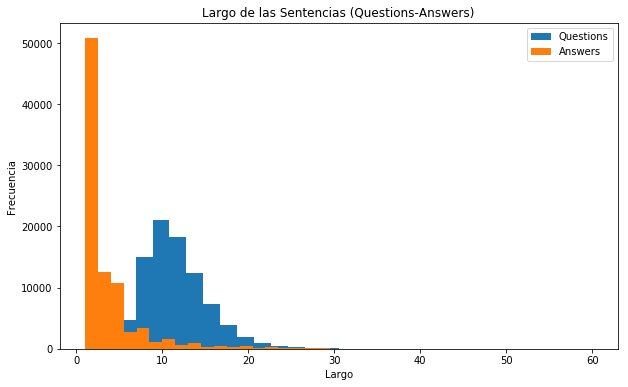

In [15]:
plt.figure(figsize=(10,6))
plt.hist(largos_sentencias, bins=30, label="Questions")
plt.hist(largos_sentenciasA, bins=30, label="Answers")
plt.title("Largo de las Sentencias (Questions-Answers)")
plt.ylabel("Frecuencia")
plt.xlabel("Largo")
plt.legend(loc="upper right")
plt.show()

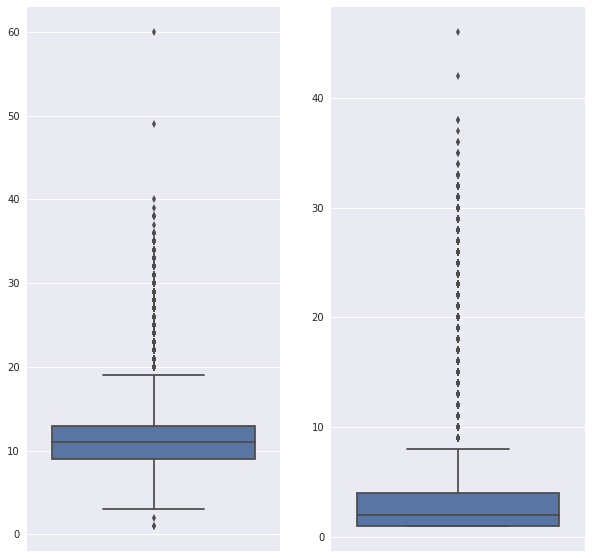

In [18]:
f, axes = plt.subplots(1, 2)
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(largos_sentencias,orient='v' , ax=axes[0])
sns.boxplot(largos_sentenciasA,orient='v' , ax=axes[1])

plt.show()

In [19]:
print ("La sentencia Question más larga tiene", max(largos_sentencias),"palabras")
print ("La sentencia Question más corta tiene", min(largos_sentencias),"palabras")
print ("-------------")
print ("La sentencia Answer más larga tiene", max(largos_sentenciasA),"palabras")
print ("La sentencia Answer más corta tiene", min(largos_sentenciasA),"palabras")

La sentencia Question más larga tiene 60 palabras
La sentencia Question más corta tiene 1 palabras
-------------
La sentencia Answer más larga tiene 46 palabras
La sentencia Answer más corta tiene 1 palabras


## Comentarios extras!! -cantidad de outliers

### Distribución de palabras en Questions y en Answers

> c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente *respondida* ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?




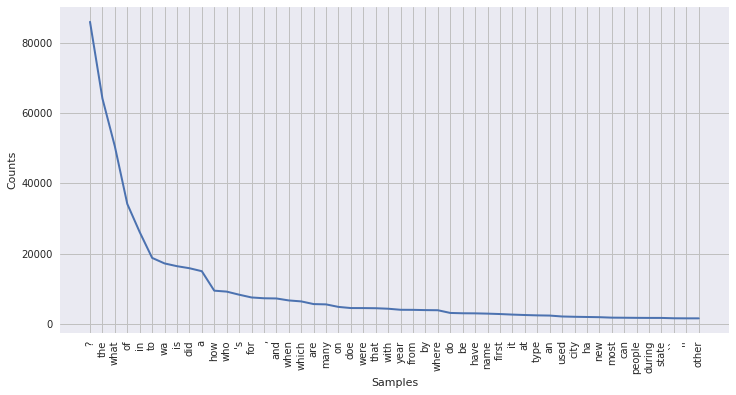

In [20]:
vocabulario_Q=word_tokenize("")
for sentence in train_questions_Lem:
        vocabulario_Q += sentence
        
        
fdist = nltk.FreqDist(vocabulario_Q)
plt.figure(figsize=(12,6))
fdist.plot(50)

(-0.5, 499.5, 499.5, -0.5)

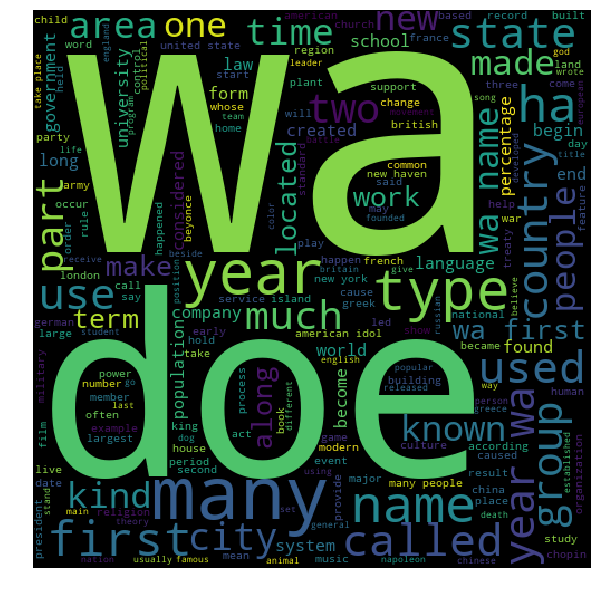

In [21]:
from wordcloud import WordCloud
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html?highlight=generate%20wordcloud#wordcloud.WordCloud.generate

cloud = WordCloud(width=500, height=500).generate(', '.join(vocabulario_Q))#" ".join(train_qs.astype(str)))
plt.figure(figsize=(10, 12))
plt.imshow(cloud)
plt.axis('off')

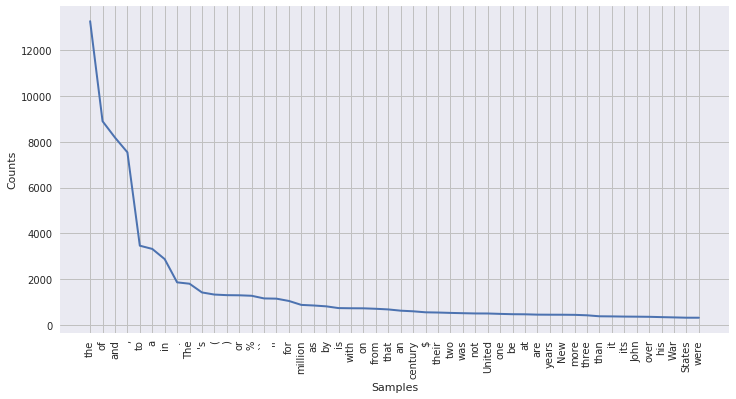

In [22]:
vocabulario_A=word_tokenize("")
for sentence in train_answers:
        vocabulario_A += sentence
        
        
fdistA = nltk.FreqDist(vocabulario_A)
plt.figure(figsize=(12,6))
fdistA.plot(50)

(-0.5, 499.5, 499.5, -0.5)

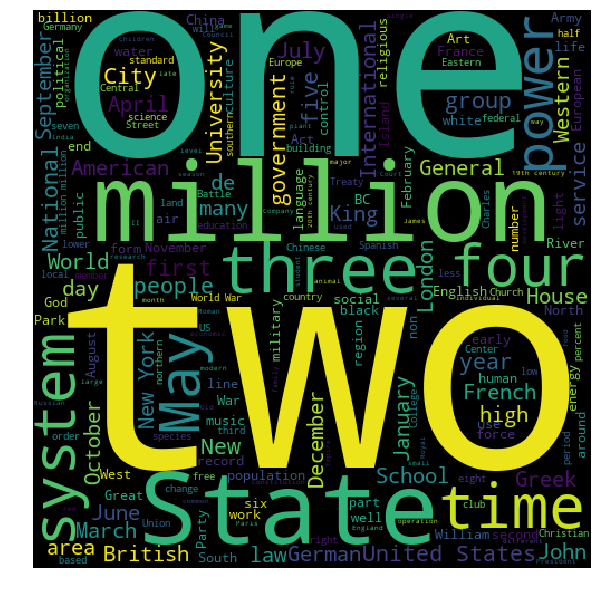

In [23]:
cloudA = WordCloud(width=500, height=500).generate(', '.join(vocabulario_A))#" ".join(train_qs.astype(str)))
plt.figure(figsize=(10, 12))
plt.imshow(cloudA)
plt.axis('off')

### comentar palabras frecuentes

sdsdadasdasd

In [24]:
vocab_answer = list(set(vocabulario_A))
vocab_answer = ["#end"]+ vocab_answer
print('Posibles palabras para respuestas (cantidad de palabras A en training set) considerando #end :', len(vocab_answer))
print("Palabras para respuestas (A en training set) sin considerar carácter 'Fin de respuesta' (#end) :", len(vocab_answer)-1)

vocab_question = list(set(vocabulario_Q))
print('Posibles palabras para Preguntas (cantidad de palabras Q en training set) :', len(vocab_question))


Posibles palabras para respuestas (cantidad de palabras A en training set) considerando #end : 47423
Palabras para respuestas (A en training set) sin considerar carácter 'Fin de respuesta' (#end) : 47422
Posibles palabras para Preguntas (cantidad de palabras Q en training set) : 35456


In [25]:
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}

vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}
indices_vocabQ = {i: c for i, c in enumerate(vocab_question)}

### comentar lo que se hizo y para qué' 

> d) Codifique los tokens (palabras) de cada texto que utilizará.


In [26]:
Xtrain_question = [[vocabQ_indices[palabra] for palabra in sentence ] for sentence in train_questions_Lem]
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtest_question = [[vocabQ_indices[palabra] for palabra in sentence ] for sentence in train_questions_Lem]


Es necesario transformar los textos (entrenamiento y testing) para que puedan ser entregados apropiadamente a la red a entrenar a continuación. Para ello se codifica cada posible palabra de cada sentencia (lemma) a un número (o índice),


### Poda de sentencias (Padding)
[https://web.stanford.edu/class/cs224n/reports/2761899.pdf]

> Luego de ésto realice un *padding* a ambas secuencias, entrada y salida de entrenamiento y a la entrada del conjunto de pruebas. Comente sobre las dimensionalidades finales de los conjuntos de entrenamiento y de prueba.



In [27]:
from keras.preprocessing import sequence

max_input_lenght=max(largos_sentencias)
max_output_lenght=max(largos_sentenciasA)

Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])

#https://www.programcreek.com/python/example/106831/keras.preprocessing.sequence.pad_sequences

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Se dejó post padding puesto que uno de los trabajos previos sobre el dataset en cuestión SQuAD acusó buenos resultados sobre esta decisión
[https://www.programcreek.com/python/example/106831/keras.preprocessing.sequence.pad_sequences] 

#### de todos modos probar pre padding

In [26]:
Xtrain_question_pre = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='pre',value=0)
Xtest_question_pre = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='pre',value=0)
X_answers_pre = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='pre',value=vocabA_indices["#end"])

In [27]:
print ("Post Padding:\n")
print ("Dimensiones del conjunto de entrenamiento [entradas/questions]", Xtrain_question.shape)
print ("Dimensiones del conjunto de entrenamiento [salidas/answer]", X_answers.shape)
print ("Dimensiones del conjunto de testing [entradas/questions]", Xtest_question.shape)

print ("\n\nPre Padding:\n")
print ("Dimensiones del conjunto de entrenamiento [entradas/questions]", Xtrain_question_pre.shape)
print ("Dimensiones del conjunto de entrenamiento [salidas/answer]", X_answers_pre.shape)
print ("Dimensiones del conjunto de testing [entradas/questions]", Xtest_question_pre.shape)

Post Padding:

Dimensiones del conjunto de entrenamiento [entradas/questions] (86821, 60)
Dimensiones del conjunto de entrenamiento [salidas/answer] (86821, 46)
Dimensiones del conjunto de testing [entradas/questions] (86821, 60)


Pre Padding:

Dimensiones del conjunto de entrenamiento [entradas/questions] (86821, 60)
Dimensiones del conjunto de entrenamiento [salidas/answer] (86821, 46)
Dimensiones del conjunto de testing [entradas/questions] (86821, 60)


In [28]:
print ("Diferencias visuales entre pre y post padding (training questions)\n")
print (Xtrain_question[5])
print (Xtrain_question_pre[5])

Diferencias visuales entre pre y post padding (training questions)

[34775 17786 32852 30664 23204 30848  2417  3945 19992 20448 24999 10309
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
[34775 17786 32852 30664 23204 30848  2417  3945 19992 20448 24999 10309
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


In [29]:
###parece que da igual si se hace pre o post
False in (Xtrain_question==Xtrain_question_pre)

False

### Comentar qué ocurre


> e) Defina el modelo *encoder-decoder* con los módulos de atención.

```python
#Encoder-Decoder modelo
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda
from keras.models import Model
from keras import backend as K
lenght_output = max_output_lenght
hidden_dim = 128
```

In [28]:
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda
from keras.models import Model
from keras import backend as K
lenght_output = max_output_lenght
hidden_dim = 128

> Defina el *encoder* y las compuertas que utilizará: CuDNNGRU,CuDNNLSTM, RNN u otra. Puede utilizar redes bidireccionales en el *encoder* ¿Esto mejora el resultado?

```python
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = gate(hidden_dim, return_sequences=True)(embedded)
```

In [29]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM

"""
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
"""

embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = LSTM(hidden_dim, return_sequences=True)(embedded)



In [30]:
#Version bidireccional
"""
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
"""

from keras.layers import Bidirectional
embedded_bi = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
layer_lstm = LSTM(units=hidden_dim,return_sequences=True)
encoder_bi = Bidirectional(layer_lstm,merge_mode='concat')(embedded_bi)




> Defina la atención $\alpha$ que se calculará sobre cada instante de tiempo $T$ computándo su atención en cada instante de tiempo de la decodificación $T'$.

```python
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)
```

In [31]:
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

In [32]:
#Version bidireccional
# compute T' importance for each step T
attention_bi = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder_bi)
#softmax a las antenciones sobre todo T
attention_bi = Permute([2, 1])(attention_bi)
attention_bi = Activation('softmax')(attention_bi) 
attention_bi = Permute([2, 1])(attention_bi)

> Aplique la atención sobre el *encoder* y genere las salidas correspondientes.

```python
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = gate(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)
```


In [33]:
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = LSTM(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)

In [34]:
#Version bidireccional
# apply the attention to encoder
sent_representation_bi = Lambda(attention_multiply)([encoder_bi, attention_bi])
layer_lstm_decoder = LSTM(units=hidden_dim,return_sequences=True)
decoder_bi = Bidirectional(layer_lstm_decoder,merge_mode='concat')(sent_representation_bi)
probabilities_bi = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder_bi)

> Defina el modelo y descríbalo adecuadamente.

```python
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()
```


In [35]:
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 64)       2269184     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60, 128)      98816       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 60, 46)       5934        lstm_1[0][0]                     
__________________________________________________________________________________________________
permute_1 

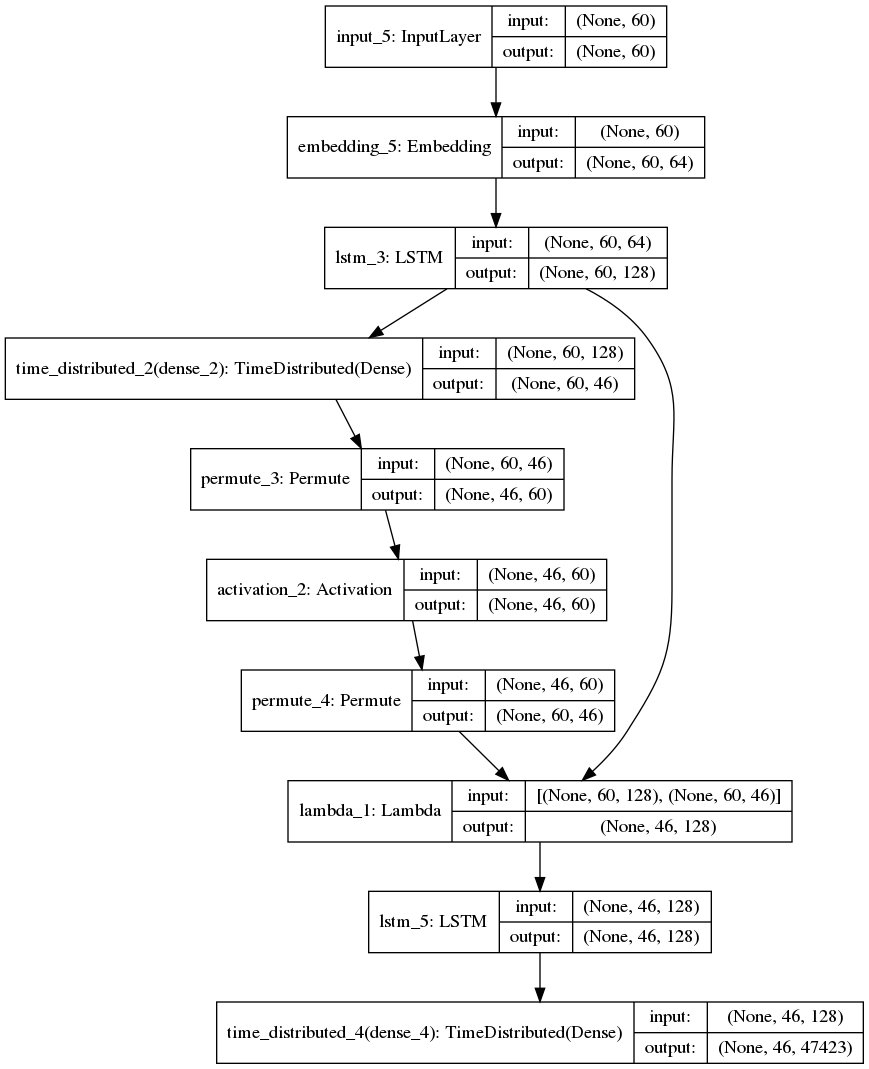

In [46]:
import os    
import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

from scipy.misc import imread
import _pickle as pickle
import numpy as np
import math

plot_model(model, to_file='model-p2-unidireccional.png', show_shapes=True)
Image(filename='model-p2-unidireccional.png')

In [36]:
#Version bidireccional
model_bi = Model(encoder_input,probabilities_bi)
model_bi.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_bi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 64)       2269184     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 256)      197632      embedding_2[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 60, 46)       11822       bidirectional_1[0][0]            
__________________________________________________________________________________________________
permute_3 

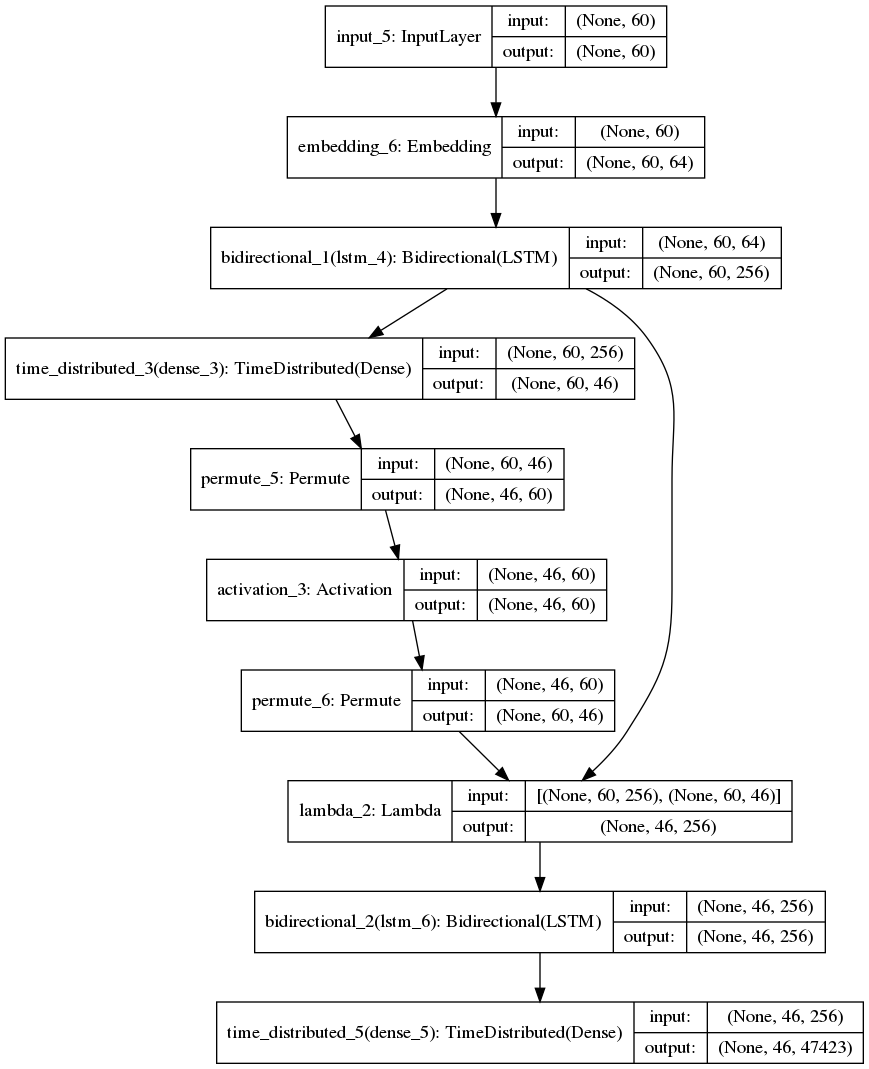

In [48]:
import os    
import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

from scipy.misc import imread
import _pickle as pickle
import numpy as np
import math

plot_model(model_bi, to_file='model-p2-bidireccional.png', show_shapes=True)
Image(filename='model-p2-bidireccional.png')


> f) Entrene el modelo por 10 *epochs* con el tamaño de batch que estime conveniente. Para ésto deberá redimensionar la salida para que tenga 3 dimensiones debido a la recurrencia.

```python
X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
X_answers.shape
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=BS,validation_split=0.2)
```
*Por temas de recursos puede optar con entrenar con una muestra más pequeña del conjunto de entrenamiento*.




In [49]:
X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
print("Nuevas dimenciones de Respuestas: ",X_answers.shape)
BS=64
#model.fit(Xtrain_question,X_answers,epochs=10,batch_size=BS,validation_split=0.2)

Nuevas dimenciones de Respuestas:  (86821, 46, 1)
Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 493s 7ms/step - loss: 1.0299 - val_loss: 0.8158
Epoch 2/10
69456/69456 [==============================] - 491s 7ms/step - loss: 0.7091 - val_loss: 0.8170
Epoch 3/10
69456/69456 [==============================] - 489s 7ms/step - loss: 0.6904 - val_loss: 0.8239
Epoch 4/10
69456/69456 [==============================] - 488s 7ms/step - loss: 0.6765 - val_loss: 0.8293
Epoch 5/10
69456/69456 [==============================] - 487s 7ms/step - loss: 0.6632 - val_loss: 0.8349
Epoch 6/10
69456/69456 [==============================] - 487s 7ms/step - loss: 0.6497 - val_loss: 0.8390
Epoch 7/10
69456/69456 [==============================] - 486s 7ms/step - loss: 0.6331 - val_loss: 0.8389
Epoch 8/10
69456/69456 [==============================] - 486s 7ms/step - loss: 0.6188 - val_loss: 0.8453
Epoch 9/10
69456/69456 [============================

In [37]:
#model.save_weights('modelo-uni.h5')
model.load_weights('modelo-uni.h5')

In [50]:
#model_bi.fit(Xtrain_question,X_answers,epochs=10,batch_size=BS,validation_split=0.2)

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 725s 10ms/step - loss: 0.9431 - val_loss: 0.8350
Epoch 2/10
69456/69456 [==============================] - 719s 10ms/step - loss: 0.7269 - val_loss: 0.8311
Epoch 3/10
69456/69456 [==============================] - 719s 10ms/step - loss: 0.7178 - val_loss: 0.8400
Epoch 4/10
69456/69456 [==============================] - 718s 10ms/step - loss: 0.6976 - val_loss: 0.8362
Epoch 5/10
69456/69456 [==============================] - 717s 10ms/step - loss: 0.6831 - val_loss: 0.8389
Epoch 6/10
69456/69456 [==============================] - 717s 10ms/step - loss: 0.6706 - val_loss: 0.8358
Epoch 7/10
69456/69456 [==============================] - 718s 10ms/step - loss: 0.6567 - val_loss: 0.8424
Epoch 8/10
69456/69456 [==============================] - 717s 10ms/step - loss: 0.6425 - val_loss: 0.8502
Epoch 9/10
69456/69456 [==============================] - 717s 10ms/step - loss: 0.6261 - val_

In [38]:
#model_bi.save_weights('modelo-bi.h5')
model_bi.load_weights('modelo-bi.h5')

> g) Muestre ejemplos de la predicción del modelo, para ésto genere una función que prediga a través de la distribución de probabilidad de la salida, de la forma que estime conveniente, cada palabra en cada instante de tiempo.

```python
def predict_words(model,example,diversity=?):
    #predict example
n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,0.85)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")
```

In [39]:
def predict_words(model,example,diversity=0.5):
    print(example)
    return model.predict(example,verbose=1)
n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    #print(Xtrain_question[0])
    #print(example)
    indexes_answer = predict_words(model,example,0.85)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")

[ 6722 32393 16567 11292 25044 16878 15520     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


ValueError: Error when checking input: expected input_1 to have shape (60,) but got array with shape (1,)


> h) Evalúe la calidad de su modelo con la métrica del *benchmark*, para ésto deberá descargar el archivo **evaluation script** y el dato **dev json** de la página oficial del dataset: https://rajpurkar.github.io/SQuAD-explorer/ y ejecutarlo de la siguiente manera dentro del *Jupyter Notebook*

```python
#evaluar resultados
!python evaluate-v2.0.py dev-v2.0.json predictions
```
> Para generar las predicciones utilice la función anteriormente definida de la siguiente manera:
```python
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()
```
Comente sobre el desempeño obtenido y porqué debiera deberse.